In [1]:
# Connecting  Google Colaboratory to Google Drive to access the necessary files
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import spacy
import string
from sklearn.model_selection import train_test_split
import google.generativeai as genai
import os
from google.colab import userdata

# User-Stories Data

### **Dataset Loading**


In [3]:
# Read the dataset (CSV file) as a pandas Dataframe
df = pd.read_csv("./gdrive/My Drive/PFE-Project/user-stories-data.csv")

### **Data Exploration**

In [ ]:
# Display the first rows of the dataset
df.head()

,Issue Key,Summary,Priority Name,Priority ID,Description
0,CLM-16730,Update Compliance Tier 2 persona to include ac...,Medium,4,"*As a*, Compliance Officer Tier 2, *I want to*..."
1,CLM-16657,Update RC518 form title under table of content...,Medium,4,"*As an* Advisor Team persona, *I want* to add ..."
2,CLM-16542,Update Display Approval UI (Parent Case Review...,Medium,4,"*As a*, Compliance Officer Tier 1, *I want* to..."
3,CLM-16537,"""Download wet sign form"" email notification wi...",Medium,4,"*As an* Advisor Team, *I want* to know when I ..."
4,CLM-16536,Staging environment colour scheme identifier,Low,5,"As an Advisor Team, I need to be able to have..."


In [ ]:
# Display the shape of the DataFrame
df.shape
print("This dataset has", df.shape[0],"rows (Instances) and",df.shape[1],"columns (Features)")

This dataset has 35 rows (Instances) and 5 columns (Features)


In [ ]:
# Display the list of the column names
df.columns

Index(['Issue Key', 'Summary', 'Priority Name', 'Priority ID', 'Description'], dtype='object')

In [ ]:
# View data types of each column
df.dtypes

Issue Key        object
Summary          object
Priority Name    object
Priority ID       int64
Description      object
dtype: object

In [ ]:
# Check for missing values
df.isnull().sum()

Issue Key        0
Summary          0
Priority Name    0
Priority ID      0
Description      0
dtype: int64

=> This output shows that there are no missing values

In [ ]:
# Check for duplicates
duplicates = df.duplicated()
print(df[duplicates])

Empty DataFrame
Columns: [Issue Key, Summary, Priority Name, Priority ID, Description]
Index: []


=> the empty DataFrame confirms that there are no duplicate rows in our dataset

##### **Issue Key Column**


In [ ]:
# Check Unique Values
df['Issue Key'].unique()

array(['CLM-16730', 'CLM-16657', 'CLM-16542', 'CLM-16537', 'CLM-16536',
       'CLM-16190', 'CLM-16189', 'CLM-15872', 'CLM-15621', 'CLM-15620',
       'CLM-15619', 'CLM-15189', 'CLM-14974', 'CLM-14923', 'CLM-14602',
       'CLM-14130', 'CLM-14052', 'CLM-14024', 'CLM-14023', 'CLM-14022',
       'CLM-14011', 'CLM-14010', 'CLM-14006', 'CLM-13998', 'CLM-13996',
       'CLM-13972', 'CLM-13903', 'CLM-13800', 'CLM-12927', 'CLM-12924',
       'CLM-12009', 'CLM-10675', 'CLM-10177', 'CLM-9777', 'CLM-7690'],
      dtype=object)

=> All issue keys are unique, since the number of unique issue keys matches the total number of rows in our dataset

##### **Description Column**

In [ ]:
# Examine sample texts from the description column
df["Description"].head()

0    *As a*, Compliance Officer Tier 2, *I want to*...
1    *As an* Advisor Team persona, *I want* to add ...
2    *As a*, Compliance Officer Tier 1, *I want* to...
3    *As an* Advisor Team, *I want* to know when I ...
4    As an Advisor Team, I  need to be able to have...
Name: Description, dtype: object

In [ ]:
# Calculate the length of each description
description_lengths = df["Description"].str.len()
description_lengths.describe()

count      35.000000
mean     2315.028571
std      1442.106802
min       527.000000
25%      1228.000000
50%      1734.000000
75%      3291.000000
max      5742.000000
Name: Description, dtype: float64

- The average description length is 2315.029 characters
- The standard deviation of description lengths is 1442.12 characters. This indicates that there is a relatively large variation in description lengths, with some descriptions being much shorter or longer than the average.
- The shortest description is 527 characters long.
- 75% of the descriptions are 3291 characters or shorter.
- The longest description is 5742 characters long.

**Based on these statistics, we can conclude that:**  
The description lengths vary significantly, ranging from 527 to 5742 characters. This variation may be attributed to the inclusion of formatting elements such as hyperlinks. Therefore, further exploration is needed to confirm this hypothesis.

In [ ]:
# Display the description with the minimum length
df["Description"].iloc[df[df["Description"].str.len() == 527].index[0]]

'As an Advisor Team, I  need to be able to have a more visual indicator that I’m in the staging environment so that I don’t onboard real clients by mistake in staging.  h2. Pre-Conditions  # An SR case is in an editable or view-only screen, OR # An NC case is in an editable or view-only screen # User is in the staging environment (STG1)  h2. Acceptance Criteria  # The case summary panel heading with blue block displaying the Case ID and Case Name must have a red background colour: HEX: #FF00000  h2. Post-Conditions  # None'

Based on these description, we can notice that the existance of various formatting elements:
- **Headings :** `h2.` `h3.`   

- **Hyperlinks :** `(https://...)`    

- **Bold Text:** `*...*` : Text enclosed  between two asterisks (*)   
  
**Observation:** We can notice that these formatting elements bear similarities to Markdown; However, they follow to a different formatting language that is specific to Jira's text editor.

This [documentation](https://jira.atlassian.com/secure/WikiRendererHelpAction.jspa?section=all) outlines additional formatting options available within Jira's environment, which may include but are not limited to:
- **Block Quotation**: `bq.`
- **Color**: `{color:red} ... {color}`
- **Images**: `!image.gif|align=right, vspace=4!` or `!image.jpg|thumbnail!`
- **Attachments**: `!media.wmv|id=media!`
- **Panels**: `{panel} ... {panel}`
- **Code**: `{code} ... {code}`                                                             
=> Therefore, further examination of these Jira-specific formatting elements within our descriptions' text will provide deeper insight into the structure and content of the descriptions.



In [5]:
# Function to check the number of rows containing a specific formatting element (within a specific column)
def check_format(column,formatting_element,pattern):
  if column.str.contains(pattern).sum()>0:
    print( "=> There are",column.str.contains(pattern).sum(),column.name,"containing",formatting_element)


In [6]:
# Check for the number of descriptions that contain specefic formatting element
check_format(df["Description"],"headings formatting elements","(?i)h\d\.")
check_format(df["Description"],"hyperlinks","https://")
check_format(df["Description"],"block quotaion formatting elements","bq.")
check_format(df["Description"],"color formatting elements","{color}")
check_format(df["Description"],"Images","!image")
check_format(df["Description"],"attachements","!media")
check_format(df["Description"],"panels","{panel}")
check_format(df["Description"],"code","{code}")
check_format(df["Description"],"tables","\|\|.*\|\|")

=> There are 29 Description containing headings formatting elements
=> There are 30 Description containing hyperlinks
=> There are 15 Description containing color formatting elements
=> There are 6 Description containing Images
=> There are 15 Description containing panels



Since these formatting elements may introduce noise, we will **remove them as part of the data cleaning process**.

In [ ]:
# Function to print the prints the top n-frequent strings that matches a specific pattern
def frequent(texts, pattern, n=5):
    all_text = " ".join(texts)  # Combine all texts into a single string
    matches = re.findall(pattern, all_text)      # Find all texts that matches the pattern
    matches_counts = pd.Series(matches).value_counts()      # Count the occurrences
    return matches_counts.head(n)

In written communication, titles are commonly used to emphasize important text.

In [ ]:
# Print the most frequent bold texts
print("Top 5 Most Frequent Bold Texts:")
top_bold_texts= frequent(df["Description"],"\*(.*?)\*")
top_bold_texts

Top 5 Most Frequent Bold Texts:


so that    20
I want     18
As an      12
            7
As a        6
dtype: int64

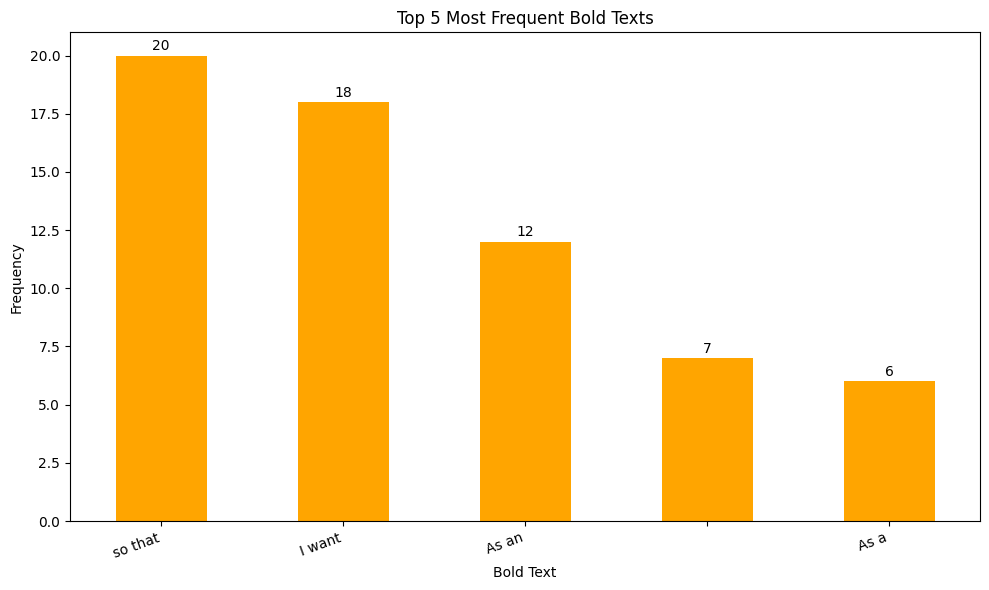

In [ ]:
# Plot histogram of the top most frequent bold texts

top_bold_texts.plot(kind='bar', color='orange' ,figsize=(10, 6))
plt.title('Top 5 Most Frequent Bold Texts')
plt.xlabel('Bold Text')
plt.ylabel('Frequency')
plt.xticks(rotation=20, ha='right')

for i, freq in enumerate(top_bold_texts):
    plt.text(i, freq + 0.1, str(freq), ha='center', va='bottom')

plt.tight_layout()
plt.show()


=> Thus, these most frequent bold texts can give as an insight into the structure of the descriptions.

The descriptions follow this format
> **`As a [role], I want [feature], So that [reason]`**


In [ ]:
# Examine sample texts from the description column
df["Description"].head()

0    *As an* Advisor Team Persona*, I want* to have...
1    *As an* Investment Advisor, *I want* the Welco...
2    *As a,* Branch Manager and Branch Administrato...
3    *As an* Advisor Team persona, *I want* to have...
4    *As an* Advisor Team persona, *I want* to have...
Name: Description, dtype: object

The above output can partially confirm our assumption.
So, we will now check for the descriptions that do not follow this specific pattern:

In [ ]:
# Check for descriptions that do not match this specific pattern
import re

pattern = "(?i)(as\s+(?:an?|a).*?i\s+(?:want|need).*?so\s+that.*)"

for index, description in df["Description"].items():
    if not(re.search(pattern, description)):
      print("Row ",index," : ", description[:100])

Row  18  :  *As* an Advisor Team persona, *I want* to select Joint Tenancy when I have chosen ‘Joint with Spouse
Row  25  :  *As* an Advisor Team persona, *I want*  the Functionality available *so that* I can select whether m
Row  32  :  This story is to address the issue in [https://canaccordgenuity.atlassian.net/browse/CLM-10137|https


=> Some descriptions appear to follow the structured format we mentioned above. However, before making any definitive judgments, it is necessary to **proceed with removing punctuation** from the sentences.  

In written communication, titles are commonly used to organize content.

In [ ]:
# Print the most frequent titles
print("Top 5 Most Frequent Titles:")
top_titles= frequent(df["Description"],"h\d\.\s*(.*?)\s{2}")
top_titles

Top 5 Most Frequent Titles:


Pre-Conditions         21
Acceptance Criteria    21
Post-Conditions        11
Post Conditions         6
Pre-Conditions:         5
dtype: int64

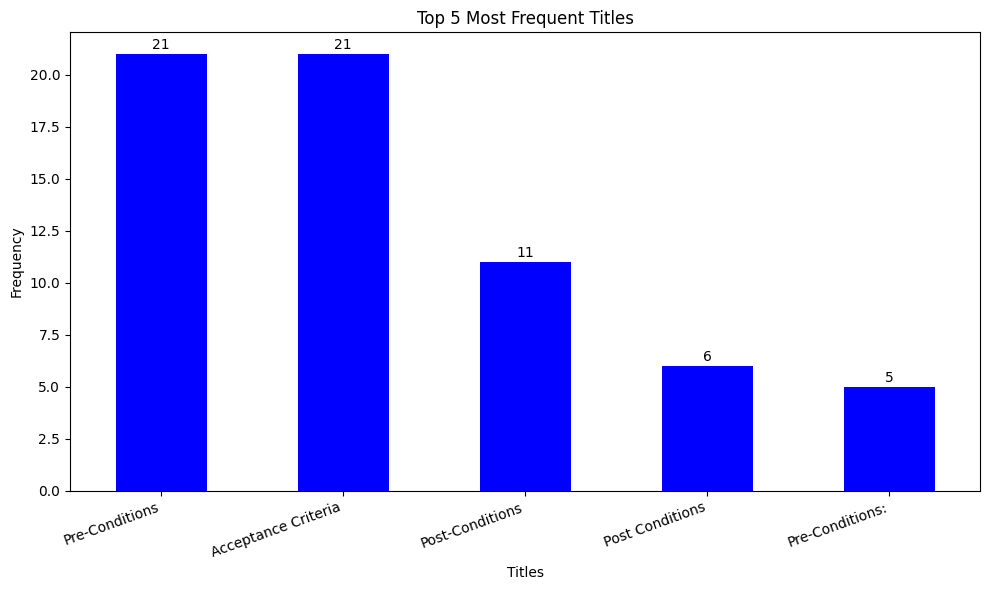

In [ ]:
# Plot histogram of the top most frequent titles

top_titles.plot(kind='bar', color='blue' ,figsize=(10, 6))
plt.title('Top 5 Most Frequent Titles')
plt.xlabel('Titles')
plt.ylabel('Frequency')
plt.xticks(rotation=20, ha='right')

for i, freq in enumerate(top_titles):
    plt.text(i, freq + 0.1, str(freq), ha='center', va='bottom')

plt.tight_layout()
plt.show()


=> Thus, these most frequent bold texts can give as an insight into the structure of the descriptions.

The descriptions follow this format
> **`As a [role], I want [feature], So that [reason].. Pre-Conditions ..Aceceptance Criteria ... Post-Conditions`**


In [ ]:
# Check for descriptions that do not match this Gherkin syntax
import re

pattern = "(?i)((?:Pre-Conditions|Pre Conditions)(?:s)?.*?Acceptance Criteria.*?(?:Post-Condition|Post Condition)(?:s)?.*)"

for index, description in df["Description"].items():
    if not(re.search(pattern, description)):
      print("Row ",index," : ", description)

Row  32  :  This story is to address the issue in [https://canaccordgenuity.atlassian.net/browse/CLM-10137|https://canaccordgenuity.atlassian.net/browse/CLM-10137|smart-link]   *Acceptance Criteria:*  # When the case is updated by a system action, the "Updated" field in left nav should display “System” instead of the default OOTB verbiage.  # This applicable to both the parent case and child case - examples below:  !image-20230217-200420.png|width=455,height=650!  !image-20230216-161901.png|width=468,height=241!  !image-20230216-161854.png|width=468,height=227!  {panel:bgColor=#eae6ff} 03/14: The RC testing of this user story will be deemed sufficient and will not need Miipe to repeat the same exercise. However, the RC test steps will need to be integrated into Miipe’s regression test package. {panel}


Most of the descriptions follow the format we mentioned above, except for row 32. This appears to be an outlier description, so we will **proceed with deleting it during the data cleaning process**.

### **Data Cleaning**

For the task at hand, we will only require the 'Issue Key' column and the 'Description' column. Therefore, we will proceed to delete the remaining columns

In [7]:
# Remove unnecessary columns
df_cleaned = df.copy()

In [8]:
df_cleaned.drop('Priority Name',axis=1,inplace=True)
df_cleaned.drop('Priority ID',axis=1,inplace=True)
df_cleaned.drop('Summary',axis=1,inplace=True)
df_cleaned.head()

,Issue Key,Description
0,CLM-16730,"*As a*, Compliance Officer Tier 2, *I want to*..."
1,CLM-16657,"*As an* Advisor Team persona, *I want* to add ..."
2,CLM-16542,"*As a*, Compliance Officer Tier 1, *I want* to..."
3,CLM-16537,"*As an* Advisor Team, *I want* to know when I ..."
4,CLM-16536,"As an Advisor Team, I need to be able to have..."


In [9]:
# Update column name
df_cleaned = df_cleaned.rename(columns={'Description': 'user_story'})
df_cleaned.columns

Index(['Issue Key', 'user_story'], dtype='object')

In [11]:
# Removing outlier descriptions (non user-stories)
# As we mentioned earlier, we have an outlier "Description" at row 32
#Drop the row having this outlier description
df_cleaned = df_cleaned.drop(32, axis=0)

### **Text Preprocessing (user_story)**

In [12]:
preprocessed_df=df_cleaned.copy()

In [15]:
# Remove Formatting elements

def remove_formatting(column):
    formatting_patterns = {
        "headings": r'(?i)h\d\.',
        "hyperlinks": r'\[([^\]]*?)\|https?://.*?\]',
        "block_quotaion": r'bq\.',
        "color": r'\{color[^}]*\}.*?\{color\}',
        "images": r'!image.*?!',
        "attachments": r'!media.*?!',
        "panels": r'\{panel[^}]*\}',
        "code": r'\{code[^}]*\}'
    }

    for key, value in formatting_patterns.items():
        column = column.str.replace(value, '', regex=True)

    return column

preprocessed_df["user_story"] = remove_formatting(preprocessed_df["user_story"])


In [16]:
# Check for the number of descriptions that contain specefic formatting element
check_format(preprocessed_df["user_story"],"headings formatting elements","(?i)h\d\.")
check_format(preprocessed_df["user_story"],"hyperlinks","https://")
check_format(preprocessed_df["user_story"],"block quotaion formatting elements","bq.")
check_format(preprocessed_df["user_story"],"color formatting elements","{color}")
check_format(preprocessed_df["user_story"],"Images","!image")
check_format(preprocessed_df["user_story"],"attachements","!media")
check_format(preprocessed_df["user_story"],"panels","{panel}")
check_format(preprocessed_df["user_story"],"code","{code}")

=> Since the output is empty ==> the formatting elements are successfully deleted!

In [17]:
def show_punctuations(text_column):
    all_punctuations = set()
    for text in text_column:
        all_punctuations.update(char for char in text if char in string.punctuation)
    return all_punctuations

In [18]:
desc_punct = show_punctuations(preprocessed_df["user_story"])
print(desc_punct)

{'>', ',', '<', '?', ']', '=', '[', '(', '-', '*', ')', ':', '+', '_', '&', '%', '!', '~', '"', "'", '/', '#', '|', '.', ';'}


In [19]:
def remove_punctuation(text):
    return ''.join(char for char in text if char not in string.punctuation)
preprocessed_df["user_story"] = preprocessed_df["user_story"].apply(remove_punctuation)
desc_punct = show_punctuations(preprocessed_df["user_story"])
desc_punct

set()

In [20]:
# remove unnecessary white spaces
preprocessed_df["user_story"] = preprocessed_df["user_story"].str.replace('\s+', ' ', regex=True)

In [21]:
df_user_story=preprocessed_df.copy()

# STP Data


### **Data Extraction (From Excel Files) + Formatting**


In [28]:
import os
drive_path = '/content/gdrive/My Drive/PFE-Project/STPs'

In [29]:
data = []

for file in os.listdir(drive_path):
    if file.endswith('.xlsx'):
        df = pd.read_excel(os.path.join(drive_path, file)) # excel to pandas dataframe

        columns_to_drop = ['Test Case ID', 'AC#', 'test case type',"Test case Item","Test Scenario/Summary ",'Comments']
        df = df.drop(columns_to_drop, axis=1)

        # Rename columns
        new_column_names = {'Test Scenario/General Description ': 'Test Case Description', 'input data/precondition': 'Preconditions', 'expected result': 'Expected Result', 'steps': 'Steps'}
        df = df.rename(columns=new_column_names)

        keep_cols=['Test Case Description', 'Preconditions', "Steps",'Expected Result']

        # Combine all rows into a single paragraph
        stp = ''
        for i in range(1, len(df) + 1):
          row = df.iloc[i-1]
          test_case = ''
          for col, val in zip(keep_cols, row):
              if col == 'Preconditions' and pd.notna(val):
                  test_case += f'{col}:\n{val}\n'
              elif isinstance(val, str) and val.endswith('\n\n '):
                  val = val.replace('\n\n ', '\n')
                  test_case += f'{col}: {val}'
              else:
                  test_case += f'{col}: {val}\n'
          test_case = f"Test Case {i}:\n" + test_case + '\n'
          stp += test_case

        new_row = pd.DataFrame({'file_name': file, 'STP': [stp]}, index=[0])
        data.append(new_row)

df_STP = pd.concat(data, ignore_index=True)
df_STP.shape

(43, 2)

### **Data Exploration**

In [ ]:
# Display Shape
df_STP.shape
print("This dataset has", df_STP.shape[0],"rows (Instances) and",df_STP.shape[1],"columns (Features)")

This dataset has 43 rows (Instances) and 2 columns (Features)


In [ ]:
# Display head
df_STP.head()

,file_name,STP
0,CLM-13972.xlsx,Test Case 1:\nTest Case Description: Update Cl...
1,CLM-14010.xlsx,Test Case 1:\nTest Case Description: Validate ...
2,CLM-14023.xlsx,Test Case 1:\nTest Case Description: Update 'I...
3,CLM-14024.xlsx,Test Case 1:\nTest Case Description: Update Di...
4,CLM-14006.xlsx,Test Case 1:\nTest Case Description: Update Ne...


In [ ]:
# Check for missing values
df_STP.isnull().sum()

file_name    0
STP          0
dtype: int64

=> This output shows that there are no missing values

In [ ]:
# Check for duplicates
duplicates = df_STP.duplicated()
print(df_STP[duplicates])

Empty DataFrame
Columns: [file_name, STP]
Index: []


=> the empty DataFrame shows that there are are no duplicate rows in our dataset

### **Data Preprocessing**

In [30]:
# Data cleaning
df_STP['file_name'] = df_STP['file_name'].str.replace('.xlsx', '')
df_STP.head()

,file_name,STP
0,CLM-13972,Test Case 1:\nTest Case Description: Update Cl...
1,CLM-14010,Test Case 1:\nTest Case Description: Validate ...
2,CLM-14023,Test Case 1:\nTest Case Description: Update 'I...
3,CLM-14024,Test Case 1:\nTest Case Description: Update Di...
4,CLM-14006,Test Case 1:\nTest Case Description: Update Ne...


# Final Dataset

In [31]:
# Merge the STP dataframe with User-stories Dataframe on condition where issue_key equals file_name
concat_df = pd.merge(df_user_story, df_STP, left_on='Issue Key', right_on='file_name')

# Select specific columns for the new DataFrame
dataset = concat_df[['Issue Key', 'user_story', 'STP']]

dataset.head()

,Issue Key,user_story,STP
0,CLM-16730,As a Compliance Officer Tier 2 I want to be ab...,Test Case 1:\nTest Case Description: Review if...
1,CLM-16657,As an Advisor Team persona I want to add holde...,Test Case 1:\nTest Case Description: RC518 for...
2,CLM-16542,As a Compliance Officer Tier 1 I want to be ab...,Test Case 1:\nTest Case Description: Review if...
3,CLM-16537,As an Advisor Team I want to know when I can c...,Test Case 1:\nTest Case Description: nan\nPrec...
4,CLM-16536,As an Advisor Team I need to be able to have a...,Test Case 1:\nTest Case Description: Staging e...


In [32]:
dataset.shape

(34, 3)

In [34]:
# Export the dataset to a CSV file
dataset.to_csv('dataset(STP_text).csv', index=False, encoding='utf-8')

# Prepare Data for RAG ( Retrieval-Augmented Generation )

#### Prepare Story_STP database



In [ ]:
import sqlite3

# Connect to the database
con = sqlite3.connect("Story_STP.db")
cursor = con.cursor()

# Create the table
cursor.execute("""CREATE TABLE IF NOT EXISTS Story_STP (
    user_story TEXT,
    STP TEXT
)""")

# Insert data into the table
for i in range(len(dataset)):
    user_story = dataset.iloc[i]["user_story"]
    STP = dataset.iloc[i]["STP"]
    cursor.execute("""INSERT INTO Story_STP (user_story, STP)
                    VALUES (?, ?)""", (user_story, STP))

# Commit the changes
con.commit()

# Close the connection
con.close()

#### Prepare embedded user-stories


In [ ]:
!pip install sentence_transformers

In [36]:
from sentence_transformers import SentenceTransformer

In [37]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Encode the user stories
embedded_data = model.encode(dataset['user_story'])

# Save the encoded data to a a numpy file
file_path_encoded = "/content/embedded_userstories.npy"
np.save(file_path_encoded, embedded_data)

In [ ]:
# Load embedded data from the file
file_path_encoded = "/content/embedded_userstories.npy"
embedded_data= np.load(file_path_encoded)
print(embedded_data)

[[-0.300095   -0.05475002 -0.22116171 ... -0.3204844  -0.06531768
  -0.02751713]
 [-0.4216492  -0.06302075 -0.4041384  ...  0.06485933 -0.11271043
  -0.09508252]
 [-0.24113911  0.06821347 -0.2694906  ... -0.06105834 -0.02052812
   0.04761077]
 ...
 [-0.21977013  0.04846772 -0.17694476 ... -0.32224166 -0.16216823
  -0.00345388]
 [-0.2685898   0.01311849 -0.13105828 ...  0.1990345  -0.09229769
  -0.0022957 ]
 [-0.04075069 -0.38278276 -0.09150532 ... -0.073023    0.00172745
  -0.02125239]]


In [ ]:
type(embedded_data)

numpy.ndarray